array([[11.52607545,  4.59519449,  4.67555701,  4.59757868],
       [11.51414772,  5.7042166 ,  4.66389146,  4.59240007],
       [11.51406205,  6.18192544,  4.8720547 ,  4.61013212],
       [11.49450031,  6.62279212,  5.14522631,  4.60276751],
       [11.53503059,  7.02974585,  5.47090452,  4.65353381],
       [11.46530398,  7.30293166,  5.825349  ,  4.63586084],
       [11.5163372 ,  7.69529132,  6.19315154,  4.65728745],
       [11.47534268,  8.01080665,  6.55537119,  4.67606772],
       [11.45870711,  8.34588359,  6.8696154 ,  4.73932252],
       [11.44187738,  8.71730099,  7.20528118,  4.82691973],
       [11.39470489,  8.98509996,  7.54356708,  4.85676344],
       [11.36741762,  9.34880815,  7.9010946 ,  4.944803  ],
       [11.28766857,  9.60523149,  8.22811895,  5.04212502],
       [11.17344719,  9.86659299,  8.47774216,  5.19784412],
       [11.0964259 , 10.20876615,  8.80965579,  5.31850034],
       [10.9348282 , 10.39803116,  9.06042044,  5.46071047],
       [10.86665901, 10.

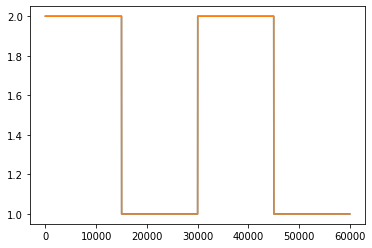

In [1]:
import numpy as np
import pickle
import torch
import scipy
import argparse
import sys
from arma import ode_system, solve_magi
from arma import matrix
import time
import pickle
import matplotlib.pyplot as plt
import scipy.special as fun
from multiprocessing import Pool


N = 100000.
param=[0.1, 0.1, 0.05]
days = 60
def gen_data(beta_series=None, random=True, lambda0=0.05, days=days, obs_per_day=1, state0=[100000., 100., 100., 100.], 
             lb= 0.5, ub=1.5, linspace=1000, noise=0.03,seed=5):
    """
    random: If True, simulate a change point arrival as poisson process with rate lambda0. 
            If False, input a series of beta with dimension days * obs_per_day * linspace
    lambda0: rate of Poisson arrival
    obs_per_day: measurement per day
    state0: population of S, E, I and D state
    linspace: discretization of 
    params: parameter: [beta, ve, vi, pd]
    noise: noise level of the observation
    param: ve, vi, pd = [0.1, 0.1, 0.05]
    """
    # number of change points
    global N, param
    state_ls = np.ones((days * obs_per_day * linspace, 4))
    step_size = 1. / (linspace * obs_per_day)
    if beta_series is None:
        if seed is not None:
            np.random.seed(seed)
        n_cp = np.random.poisson(lambda0 * days)
        beta_series = np.zeros(days * obs_per_day * linspace)
        
        if seed is not None:
            np.random.seed(seed)
        time = np.sort(np.random.uniform(1, days * obs_per_day * linspace, n_cp).astype(int))
        if seed is not None:
            np.random.seed(seed)
        val = np.random.uniform(lb, ub, n_cp+1)
        for i in range(time[0]):
            beta_series[i] = val[0]
        for idx in range(0, n_cp-1):
            beta_series[time[idx]:time[idx+1]] = val[idx+1]
        for i in range(time[-1], len(beta_series)):
            beta_series[time[-1]:] = val[-1]
    state_ls = np.zeros((days * linspace * obs_per_day, 4))    
    for i in range(4):
        state_ls[0][i] = state0[i]
    ve, vi, pd = param[0], param[1], param[2]
    plt.plot(beta_series)
    for i in range(1, linspace * days * obs_per_day):
        state_ls[i][0] = state_ls[i - 1][0] - step_size * beta_series[i-1] * state_ls[i - 1][2] * state_ls[i - 1][0] / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * beta_series[i-1] * state_ls[i - 1][2] * state_ls[i - 1][0] / N - step_size * ve * state_ls[i - 1][1]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * ve * state_ls[i - 1][1] - step_size * state_ls[i - 1][2] * vi
        state_ls[i][3] = state_ls[i - 1][3] + step_size * state_ls[i - 1][2] * vi * pd
    states = state_ls[::linspace]
    if seed is not None:
        np.random.seed(seed)
    states2 = states * np.random.normal(1, noise, states.shape)
    return np.log(states2), np.log(states), beta_series#, n_cp, time/(linspace*obs_per_day), beta_series  

x = np.linspace(0, 4 * np.pi, 60000)
# beta_series0 = 0.5 * np.sin(x) + 1.5
beta_series = np.concatenate((2.0 * np.ones(15000), 1.0 * np.ones(15000), 2.0 * np.ones(15000), 1.0 * np.ones(15000)))
observations, true_data, true_beta = gen_data(beta_series=beta_series) # beta_series=beta_series
plt.plot(beta_series)
observations

In [2]:
# Derivatves of X according to the ODE structure
def fOde(theta, x):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[0] * np.exp(logI) / N  # (1)
    logEdt = theta[0] * np.exp(logS + logI - logE) / N - theta[1]  # (2)
    logIdt = np.exp(logE - logI) * theta[1] - theta[2]  # (3)
    logDdt = np.exp(logI - logD) * 0.25 * theta[3] * theta[2]  # (4)
    return np.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


# Derivatives of X
def fOdeDx(theta, x):
    """
    returns derivation of x given theta
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    resultDx = np.zeros(shape=[np.shape(x)[0], np.shape(x)[1], np.shape(x)[1]])
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程关于第i个状态求导
    # (1) / dI
    resultDx[:, 2, 0] = -theta[0] * np.exp(logI) / N
    # (1) / dS, (1) /dE, (1) / dD = 0
    # (2) / dS
    resultDx[:, 0, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dE
    resultDx[:, 1, 1] = -theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dI
    resultDx[:, 2, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dD = 0
    # (3) / dS = 0
    # (3) / dE
    resultDx[:, 1, 2] = np.exp(logE - logI) * theta[1]
    # (3) / dI
    resultDx[:, 2, 2] = -np.exp(logE - logI) * theta[1]
    # (3) / dD = 0, (4) / dS, dE = 0
    # (4) / dI
    resultDx[:, 2, 3] = np.exp(logI - logD) * 0.25 * theta[3] * theta[2]
    # (4) / dD
    resultDx[:, 3, 3] = -np.exp(logI - logD) * 0.25 * theta[3] * theta[2]
    return resultDx


def fOdeDtheta(theta, x):
    """
    returns derivation of theta given x
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    global N
    resultDtheta = np.zeros(shape=[np.shape(x)[0], np.shape(theta)[0], np.shape(x)[1]])
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程对theta_i求导
    # (1) / dRe
    resultDtheta[:, 0, 0] = -np.exp(logI) / N
    # (2) / d theta[0]
    resultDtheta[:, 0, 1] = np.exp(logS + logI - logE) / N
    # (2) / theta[1]
    resultDtheta[:, 1, 1] = -1.
    # (3) / dtheta[1]
    resultDtheta[:, 1, 2] = np.exp(logE - logI)
    # (3) / dtheta[2]
    resultDtheta[:, 2, 2] = -1.
    # (4) / theta[2]
    resultDtheta[:, 2, 3] = np.exp(logI - logD) * 0.25 * theta[3] 
    # (4) / theta[3]
    resultDtheta[:, 3, 3] = np.exp(logI - logD) * 0.25 * theta[2]
    return resultDtheta



def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])





days = 60
discretization = 1
obs_per_day = 1
theta_lowerbound=np.array([0., 0., 0., 0.])
theta_upperbound=np.array([np.inf, 1., 1., 1.])
param_names = ['re', 've', 'vi', 'pd']
use_trajectory='inferred'
learning_rate=np.array([1e-4, 1e-3, 1e-5])
n_iter = [15001, 80000, 15000, 60000]
yobs = observations
start_time = time.time()
nobs, p_dim = yobs.shape[0], yobs.shape[1]
n_points = days * discretization
theta_dim = theta_lowerbound.shape[0]
d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                         thetaLowerBound=theta_lowerbound,
                         thetaUpperBound=theta_upperbound)
tvecObs = np.arange(0, days, 1. / obs_per_day)
tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
yFull = np.ndarray([n_points, p_dim])
yFull.fill(np.nan)
yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
xInitExogenous = np.zeros_like(yFull)
# interpolate: find the ydata of tvecFull given observations
for i in range(p_dim):
    xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])


# First stage: use MAGI package to optimize theta as constant #####################


result = solve_magi(
    yFull,
    Ode_system,
    tvecFull,
    sigmaExogenous=np.array([]),
    phiExogenous=np.array([[]]),
    xInitExogenous=xInitExogenous,
    thetaInitExogenous=np.array([]),
    muExogenous=np.array([[]]),
    dotmuExogenous=np.array([[]]),
    priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
    priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
    priorTemperatureObs=1.0,
    kernel="generalMatern",
    nstepsHmc=100,
    burninRatioHmc=0.5,
    niterHmc=n_iter[0],
    stepSizeFactorHmc=0.01,
    nEpoch=1,
    bandSize=40,
    useFrequencyBasedPrior=True,
    useBand=False,
    useMean=False,
    useScalerSigma=False,
    useFixedSigma=False,
    verbose=True)
samplesCpp = result['samplesCpp']
llikId = 0
xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
# dimension of theta
thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
burnin = int(n_iter[0] * 0.5)
xsampled = samplesCpp[xId, (burnin + 1):]
xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
CovAllDimensionsPyList = []
thetaSampled = samplesCpp[thetaId, (burnin + 1):]
inferred_theta = np.mean(thetaSampled, axis=-1)
print(inferred_theta)
sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
inferred_sigma = np.mean(sigmaSampled, axis=-1)
inferred_trajectory = np.mean(xsampled, axis=-1)
for each_gpcov in result['result_solved'].covAllDimensions:
        each_pycov = dict(
            Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
            Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
            mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
        )
        CovAllDimensionsPyList.append(each_pycov)

[1.47437248 0.1019013  0.10768997 0.18708993]


In [3]:
def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[:, 0] * torch.exp(logI) / N  # (1)
    logEdt = theta[:, 0] * torch.exp(logS + logI - logE) / N - constant_param_ls[0]  # (2)
    logIdt = torch.exp(logE - logI) * constant_param_ls[0] - constant_param_ls[1]  # (3)
    # reparametrize on pd
    logDdt = torch.exp(logI - logD) * 0.25 * constant_param_ls[1] * constant_param_ls[2]  # (4)
    return torch.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


from scipy.stats import poisson

is_time_varying=[True, False, False, False]
TV_theta_mean = np.zeros(int(sum(is_time_varying)))
tv_index = 0
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == True:
        TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
        tv_index += 1
        
if use_trajectory == 'observation':
    pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
elif use_trajectory == 'inferred':
    pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
else:
    raise ValueError
tmp1 = np.array([TV_theta_mean])
initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == 0:
        param_name = param_names[thetaEachDim]
        locals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double)
        time_constant_param_ls.append(eval(param_name))

ydata = torch.from_numpy(yFull).double()
priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=10000, gamma=0.5)
cur_loss = np.inf
# Define event
A_cur = np.ones(yFull.shape[0])
A_cur[0] = 1
# Prior probability

# Define theta
theta_cur = torch.ones(yFull.shape[0]) * inferred_theta[0]
theta_cur.requires_grad = True
x_cur = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
sigma2_0 = 0.01

def BM_likelihood(xlatent, theta, time_constant_param_ls, sigma, A, ydata=ydata, CovAllDimensionsPyList=CovAllDimensionsPyList, fOdeTorch=fOdeTorch,
                                 priorTemperature=priorTemperature, obs_per_day=obs_per_day, theta_min=0.5, theta_max=2.0, sigma2_0=sigma2_0):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    prior = torch.zeros(1)
    for idx in range(A.shape[0]-1):
        if A[idx] == 0:
            prior += log_pdf(theta[idx+1]- theta[idx], sigma2_0/obs_per_day)
        else:
            prior += -torch.log(torch.tensor(theta_max-theta_min))
    return torch.sum(res)+ prior

ydata = torch.from_numpy(yFull).double()
priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=10000, gamma=0.5)
cur_loss = np.inf

# for epoch in range(n_iter[1]):
#     pointwise_optimizer.zero_grad()
#     # compute loss function
#     llik = BM_likelihood(A, pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, sigma_torch,
#                                         ydata, CovAllDimensionsPyList, fOdeTorch,
#                                         priorTemperature, obs_per_day)
#     new_loss = -llik
#     if epoch % 200 == 0:
#         print(epoch, new_loss.item())
#         diff = new_loss.item() - cur_loss
#         if torch.isnan(new_loss) == False and diff > -0.1 and diff < 0.1:
#             break
#         cur_loss = new_loss.item()
#     new_loss.backward()
#     pointwise_optimizer.step()
#     pointwise_lr_scheduler.step()

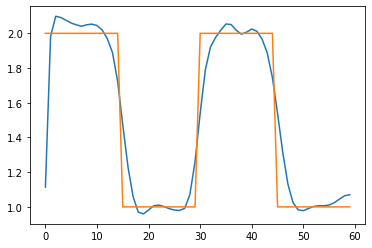

In [20]:
plt.plot(pointwise_theta_torch[:, 0].detach().numpy())
plt.plot(beta_series[::1000])

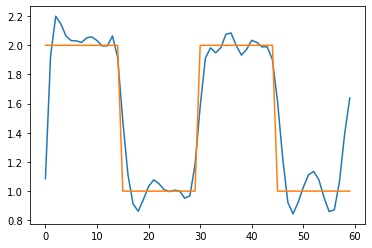

In [22]:
plt.plot(pointwise_theta_torch[:, 0].detach().numpy())
plt.plot(beta_series[::1000])

In [4]:
def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, obs_per_day, positive_param=True):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res)


is_time_varying=[True, False, False, False]
TV_theta_mean = np.zeros(int(sum(is_time_varying)))
tv_index = 0
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == True:
        TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
        tv_index += 1

if use_trajectory == 'observation':
    pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
elif use_trajectory == 'inferred':
    pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
else:
    raise ValueError
tmp1 = np.array([TV_theta_mean])
initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == 0:
        param_name = param_names[thetaEachDim]
        locals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double)
        time_constant_param_ls.append(eval(param_name))

ydata = torch.from_numpy(yFull).double()
priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=10000, gamma=0.5)
cur_loss = np.inf
for epoch in range(20000):
    pointwise_optimizer.zero_grad()
    # compute loss function
    llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, sigma_torch,
                                        ydata, CovAllDimensionsPyList, fOdeTorch,
                                        priorTemperature, obs_per_day)
    new_loss = -llik
    if epoch % 200 == 0:
        print(epoch, new_loss.item())
        diff = new_loss.item() - cur_loss
        if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
            break
        cur_loss = new_loss.item()
    new_loss.backward()
    pointwise_optimizer.step()
    pointwise_lr_scheduler.step()

0 -314.7930188473315


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


200 -323.1973140425933
400 -331.539330541126
600 -340.0100133222741
800 -348.40446798434147
1000 -356.676755622169
1200 -364.8530468973577
1400 -372.9924347019715
1600 -381.14737291913826
1800 -389.3529437727291
2000 -397.62808686308693
2200 -405.9754644971366
2400 -414.3877753799781
2600 -422.8464708259086
2800 -431.3138154821072
3000 -439.77712407801573
3200 -448.1646238301141
3400 -456.43171775029964
3600 -464.52352392044156
3800 -472.38629147781376
4000 -479.97500573902346
4200 -487.25673146658687
4400 -494.21673999076734
4600 -500.85231247802557
4800 -507.1774325175208
5000 -513.2149425213788
5200 -519.0022647585535
5400 -524.5657939509798
5600 -529.9405025084131
5800 -535.1567691141122
6000 -540.2418505505773
6200 -545.2188214014678
6400 -550.0960321871856
6600 -554.9133388387427
6800 -559.6858940207292
7000 -564.4018197691456
7200 -569.0838803467013
7400 -573.7420256857604
7600 -578.3861179953914
7800 -583.0252861516294
8000 -587.6626821153974
8200 -592.3210474153498
8400 -596.9

In [5]:
sigma2_0 = 0.01
def log_pdf(x, var):
    return -np.log(np.sqrt(var)) - 0.5 * np.log(2 * np.pi) - 0.5 * torch.square(x)/var
def log_prior(A, obs_per_day=2, lambda0 = 1):
    return -lambda0 * (A.shape[0] - np.sum(A)) / obs_per_day + np.sum(A) * np.log(1 - np.exp(-lambda0 / obs_per_day))

def BM_negllihood(xlatent, theta, sigma, time_constant_param_ls, A, ydata=ydata, CovAllDimensionsPyList=CovAllDimensionsPyList, fOdeTorch=fOdeTorch,
                                 priorTemperature=priorTemperature, obs_per_day=obs_per_day, theta_min=0.5, theta_max=2.5, sigma2_0=sigma2_0):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    prior = torch.zeros(1)
    for idx in range(A.shape[0]-1):
        if A[idx] == 0:
            prior += log_pdf(theta[idx+1]- theta[idx], sigma2_0/obs_per_day)
        else:
            prior += -torch.log(torch.tensor(theta_max-theta_min))
    return -(torch.sum(res)+ prior)

def vectorize(xlatent, theta, sigma, time_constant_param_ls):
        t1 = torch.reshape(xlatent.detach(), (-1,))
        t2 = torch.reshape(theta.detach(), (-1,))
        t3 = torch.reshape(sigma.detach(), (-1,))
        long_vec = torch.cat((t1, t2, t3))
        for i in range(len(time_constant_param_ls)):
            long_vec = torch.cat((long_vec, time_constant_param_ls[i].detach()))
        return long_vec

def get_dim(tensor_shape):
    if len(tensor_shape) == 0:
        return 1
    if len(tensor_shape) == 1:
        return tensor_shape[0]
    dim = 1
    for i in range(len(tensor_shape)):
        dim *= tensor_shape[i]
    return dim

def devectorize(long_tensor, xlatent_shape, theta_shape, sigma_shape, time_constant_param_dim):
    x_latent_dim = get_dim(xlatent_shape)
    theta_dim = get_dim(theta_shape)
    sigma_dim = get_dim(sigma_shape)
    time_constant_param_ls = []
    xlatent = torch.reshape(long_tensor[:x_latent_dim], xlatent_shape)
    theta = torch.reshape(long_tensor[x_latent_dim:x_latent_dim + theta_dim], theta_shape)
    sigma = torch.reshape(long_tensor[x_latent_dim + theta_dim:x_latent_dim + theta_dim + sigma_dim], sigma_shape)
    for each in range(x_latent_dim + theta_dim + sigma_dim, long_tensor.shape[0]):
        time_constant_param_ls.append(torch.tensor([long_tensor[each]]))
    return xlatent, theta, sigma, time_constant_param_ls

class HMC:
    def __init__(self, BM_negllihood, all_theta, xlatent_shape, theta_shape, sigma_shape, time_constant_param_ls, A, 
                 lsteps=200, epsilon=1e-6, n_samples=1, upper_bound=None, lower_bound=None, burn_in_ratio=0):
        self.all_theta = all_theta
        self.theta_shape = theta_shape
        self.xlatent_shape = xlatent_shape
        self.sigma_shape = sigma_shape
        self.constant_dim = len(time_constant_param_ls)
        self.lsteps = lsteps
        self.epsilon = epsilon * torch.ones(all_theta.shape)
        self.burn_in_ratio = burn_in_ratio
        self.n_samples = n_samples
        self.total_samples = int(n_samples / (1 - burn_in_ratio))
        self.BM_negllihood = BM_negllihood
        self.ub = upper_bound
        self.A = A
        if upper_bound is not None:
            if upper_bound.shape[0] != all_theta.shape[0]:
                raise ValueError
        self.lb = lower_bound
        if lower_bound is not None:
            if lower_bound.shape[0] != all_theta.shape[0]:
                raise ValueError


    def BM_negllihood_vec(self, all_theta):
        xlatent_0, theta_0, sigma_0, constant_param_ls_0 = devectorize(all_theta, self.xlatent_shape,
                                                                       self.theta_shape, self.sigma_shape,
                                                                       self.constant_dim)
        return BM_negllihood(xlatent_0, theta_0, sigma_0, constant_param_ls_0, self.A)
    def Nabla(self, theta_torch):
        theta_torch = theta_torch.detach()
        xlatent, theta, sigma, constant_param_ls = devectorize(theta_torch, self.xlatent_shape, self.theta_shape,
                                                               self.sigma_shape, self.constant_dim)
        xlatent.requires_grad = True
        theta.requires_grad = True
        sigma.requires_grad = True
        for each in constant_param_ls:
            each.requires_grad = True
        llik = self.BM_negllihood(xlatent, theta, sigma, constant_param_ls, self.A)
        llik.backward()
        constant_param_deriv_ls = []
        for each in constant_param_ls:
            constant_param_deriv_ls.append(each.grad)
        v = vectorize(xlatent.grad, theta.grad, sigma.grad, constant_param_deriv_ls)
        return v

    def sample(self, all_theta, ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature):
        def bounce(m, lb, ub):
            if lb is None and ub is None:
                return m
            if lb is None:
                max_tensor = torch.clamp(m - ub, min=0)
                return m - 2 * max_tensor
            if ub is None:
                min_tensor = torch.clamp(lb - m, min=0)
                return m + 2 * min_tensor
            if torch.sum(lb < ub) < m.shape[0]:
                raise ValueError
            if torch.sum(m >= lb) == m.shape[0] and torch.sum(m <= ub) == m.shape[0]:
                return m
            if torch.sum(m >= lb) < m.shape[0]:
                min_tensor = torch.clamp(lb - m, min=0)
                return bounce(m + 2 * min_tensor, lb, ub)
            if torch.sum(m <= ub) < m.shape[0]:
                max_tensor = torch.clamp(m - ub, min=0)
                return bounce(m - 2 * max_tensor, lb, ub)

        trace_val = np.zeros(self.total_samples)
        samples = np.zeros((self.total_samples, self.all_theta.shape[0]))
        random_ls = np.random.uniform(0, 1, self.total_samples)
        acceptance_ls = np.zeros(self.total_samples)
        nan_ls = np.zeros(self.total_samples)
        cur_theta = self.all_theta.clone().detach()
        for EachIter in range(self.total_samples):  ############
            cur_nllik_1 = self.BM_negllihood_vec(cur_theta).detach()
            rstep = torch.rand(self.epsilon.shape) * self.epsilon + self.epsilon
            p = torch.normal(mean=0., std=torch.ones(self.all_theta.shape))
            cur_p = p.clone()
            theta = cur_theta.clone()
            p = p - rstep * self.Nabla(theta).clone() / 2
            for i in range(self.lsteps):
                theta = theta + rstep * p
                nabla_torch = self.Nabla(theta).clone()
                p = p - rstep * nabla_torch
                theta = bounce(theta, self.lb, self.ub)
            p = p - rstep * self.Nabla(theta).clone() / 2

            new_nllik = self.BM_negllihood_vec(theta)
            new_p = 0.5 * torch.sum(torch.square(p))
            new_H = new_nllik + new_p
            cur_nllik = self.BM_negllihood_vec(cur_theta).detach()
            cur_H = cur_nllik + 0.5 * torch.sum(torch.square(cur_p))
#             print(new_nllik, cur_nllik)

            if torch.isnan(theta[0]) or torch.isnan(new_H):
                samples[EachIter] = cur_theta.clone()
                nan_ls[EachIter] = 1
                self.epsilon *= 0.9
                print('NaN!')
            else:
                # accept
                tmp = float(torch.exp(cur_H - new_H))
                #                 print(tmp)
                if tmp > random_ls[EachIter]:
                    samples[EachIter] = theta.clone()
                    cur_theta = theta.clone()
                    acceptance_ls[EachIter] = 1
#                     print('accept')
                else:
                    samples[EachIter] = cur_theta.clone()
#                     print('reject')
            trace_val[EachIter] = self.BM_negllihood_vec(cur_theta).item()
        return samples, trace_val, devectorize(cur_theta, self.xlatent_shape, self.theta_shape,
                                                               self.sigma_shape, self.constant_dim)


niter = 100
A_cur = np.zeros(yFull.shape[0])
A_cur[0] = 1
cur_negllik = np.inf
A_ls = []
A_ls.append(A_cur)
theta_ls = []
true_A = np.zeros(60)
true_A[14], true_A[29], true_A[44] = 1,1,1
for EachIter in range(niter):
    print('Iter ', EachIter)
    for idx in range(1, 59):
        print('Index ', idx)
        A_new = A_cur.copy()
        A_new[idx] = 1-A_cur[idx]
        all_theta_pointwise = vectorize(pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch,
                                    time_constant_param_ls)
        sampler = HMC(BM_negllihood, all_theta_pointwise,
              pointwise_xlatent_torch.shape,
              pointwise_theta_torch.shape,
              sigma_torch.shape,
              time_constant_param_ls, A_new)

        samples, new_negllik, theta_tmp = sampler.sample(all_theta_pointwise, ydata, CovAllDimensionsPyList, fOdeTorch,
                                          priorTemperature)
        
        U = np.random.uniform(0, 1)
        print(new_negllik, log_prior(A_new), cur_negllik, log_prior(A_cur))
        if np.exp(-new_negllik + log_prior(A_new) + cur_negllik - log_prior(A_cur)) > U:
            pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch, time_constant_param_ls = theta_tmp
            A_cur = A_new.copy()
            cur_negllik = new_negllik
            print('Accept')
            theta_ls.append(pointwise_theta_torch)
        else:
            print('Reject')
                
    A_ls.append(A_cur)
    print('A: ', A_cur)
    print('T: ', true_A)
    print('Changes: ', np.sum(np.abs(A_ls[-1] - A_ls[-2])))

Iter  0
Index  1
[-670.0456543] -30.865504259134376 inf -30.432752129567188
Accept
Index  2
[-667.01861572] -31.298256388701567 [-670.0456543] -30.865504259134376
Reject
Index  3
[-667.38446045] -31.298256388701567 [-670.0456543] -30.865504259134376
Reject
Index  4
[-664.50335693] -31.298256388701567 [-670.0456543] -30.865504259134376
Reject
Index  5
[-666.73394775] -31.298256388701567 [-670.0456543] -30.865504259134376
Reject
Index  6
[-666.28204346] -31.298256388701567 [-670.0456543] -30.865504259134376
Reject
Index  7
[-666.33209229] -31.298256388701567 [-670.0456543] -30.865504259134376
Reject
Index  8
[-667.35601807] -31.298256388701567 [-670.0456543] -30.865504259134376
Reject
Index  9
[-665.71032715] -31.298256388701567 [-670.0456543] -30.865504259134376
Reject
Index  10
[-667.53881836] -31.298256388701567 [-670.0456543] -30.865504259134376
Reject
Index  11
[-665.18029785] -31.298256388701567 [-670.0456543] -30.865504259134376
Reject
Index  12
[-666.91680908] -31.298256388701567

In [ ]:
[1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Text(0.5, 1.0, '$\\lambda_0=0.01$')

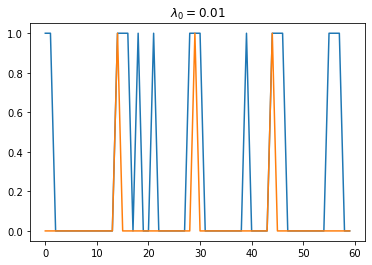

In [12]:
plt.plot(A_ls[-1])
true_A = np.zeros(60)
true_A[14], true_A[29], true_A[44] = 1,1,1
plt.plot(true_A)
plt.title(r'$\lambda_0=0.01$')

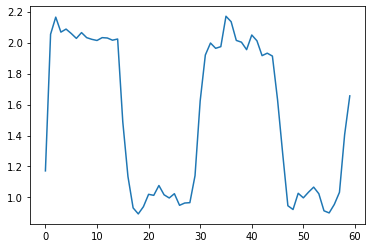

In [151]:
plt.plot(theta_tmp[1][:, 0])

In [6]:
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

for i in range(len(A_ls)):
    plt.plot(A_ls[i])
    plt.plot(true_A, label='True')
    plt.title(str(i) + ' th Iteration')
    plt.legend()
    plt.savefig('BM-plots-new/plot-'+str(i)+'.png')
    plt.clf()
# plt.plot(A_ls[-1])



<Figure size 1800x1200 with 0 Axes>

Text(0.5, 0, 'Time')

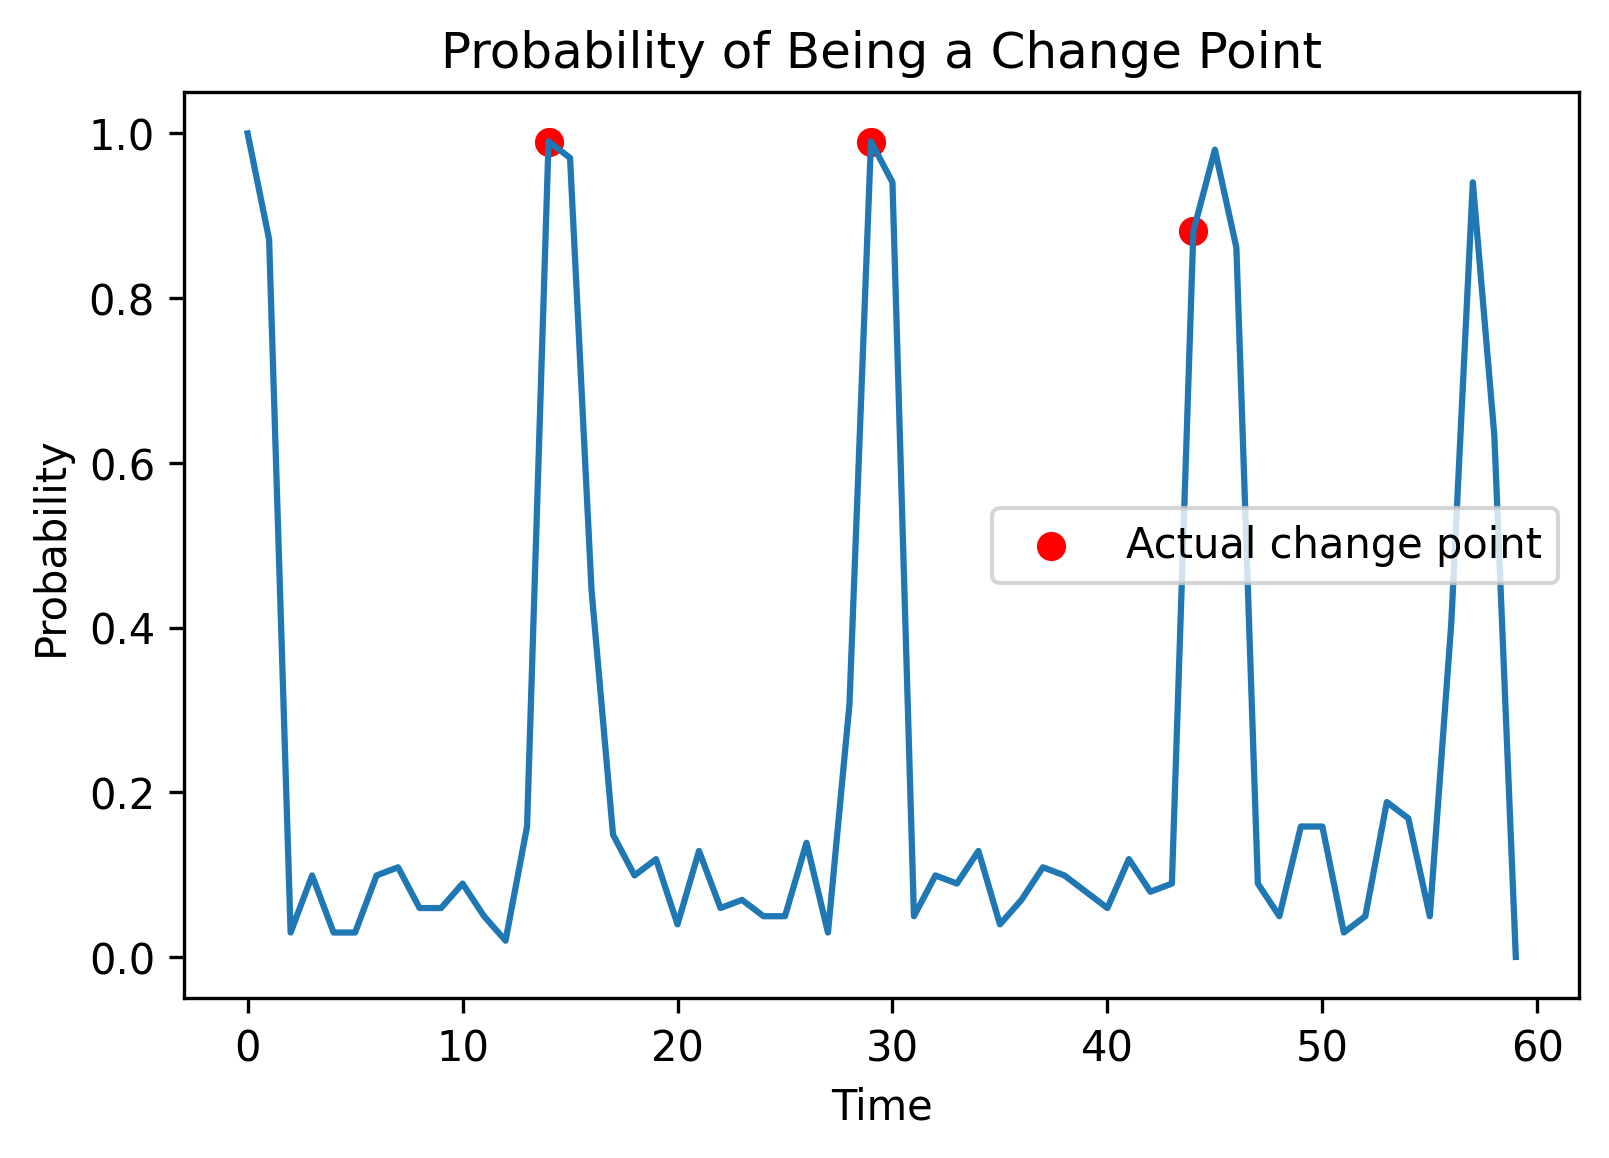

In [10]:
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率


len0 = len(A_ls)
A_np = np.zeros((len0, 60))
for i in range(len0):
    A_np[i] = A_ls[i]
mean = np.mean(A_np, axis = 0)
plt.plot(mean)
plt.scatter(np.array([14, 29, 44]), np.array([mean[14], mean[29], mean[44]]), color='red', label='Actual change point')
plt.title('Probability of Being a Change Point')
plt.legend()
plt.ylabel('Probability')
plt.xlabel('Time')

In [90]:
theta

tensor([11.6183,  5.7926,  4.6147,  4.6090, 11.6168,  6.1656,  4.8620,  4.6147,
        11.6145,  6.4960,  5.1412,  4.6221, 11.6115,  6.8112,  5.4338,  4.6319,
        11.6070,  7.1192,  5.7326,  4.6450, 11.6006,  7.4231,  6.0338,  4.6623,
        11.5919,  7.7237,  6.3353,  4.6853, 11.5802,  8.0214,  6.6360,  4.7156,
        11.5645,  8.3152,  6.9351,  4.7550, 11.5439,  8.6043,  7.2317,  4.8058,
        11.5168,  8.8869,  7.5246,  4.8700, 11.4814,  9.1616,  7.8128,  4.9499,
        11.4352,  9.4262,  8.0949,  5.0472, 11.3758,  9.6777,  8.3692,  5.1627,
        11.2991,  9.9138,  8.6338,  5.2961, 11.2011, 10.1302,  8.8864,  5.4459,
        11.0775, 10.3231,  9.1245,  5.6096, 10.9233, 10.4895,  9.3455,  5.7835,
        10.7342, 10.6263,  9.5473,  5.9633, 10.5064, 10.7310,  9.7278,  6.1450,
        10.2375, 10.8028,  9.8856,  6.3245,  9.9268, 10.8427, 10.0202,  6.4986,
         9.5759, 10.8526, 10.1320,  6.6646,  9.1881, 10.8365, 10.2218,  6.8208,
         8.7682, 10.7987, 10.2914,  6.96

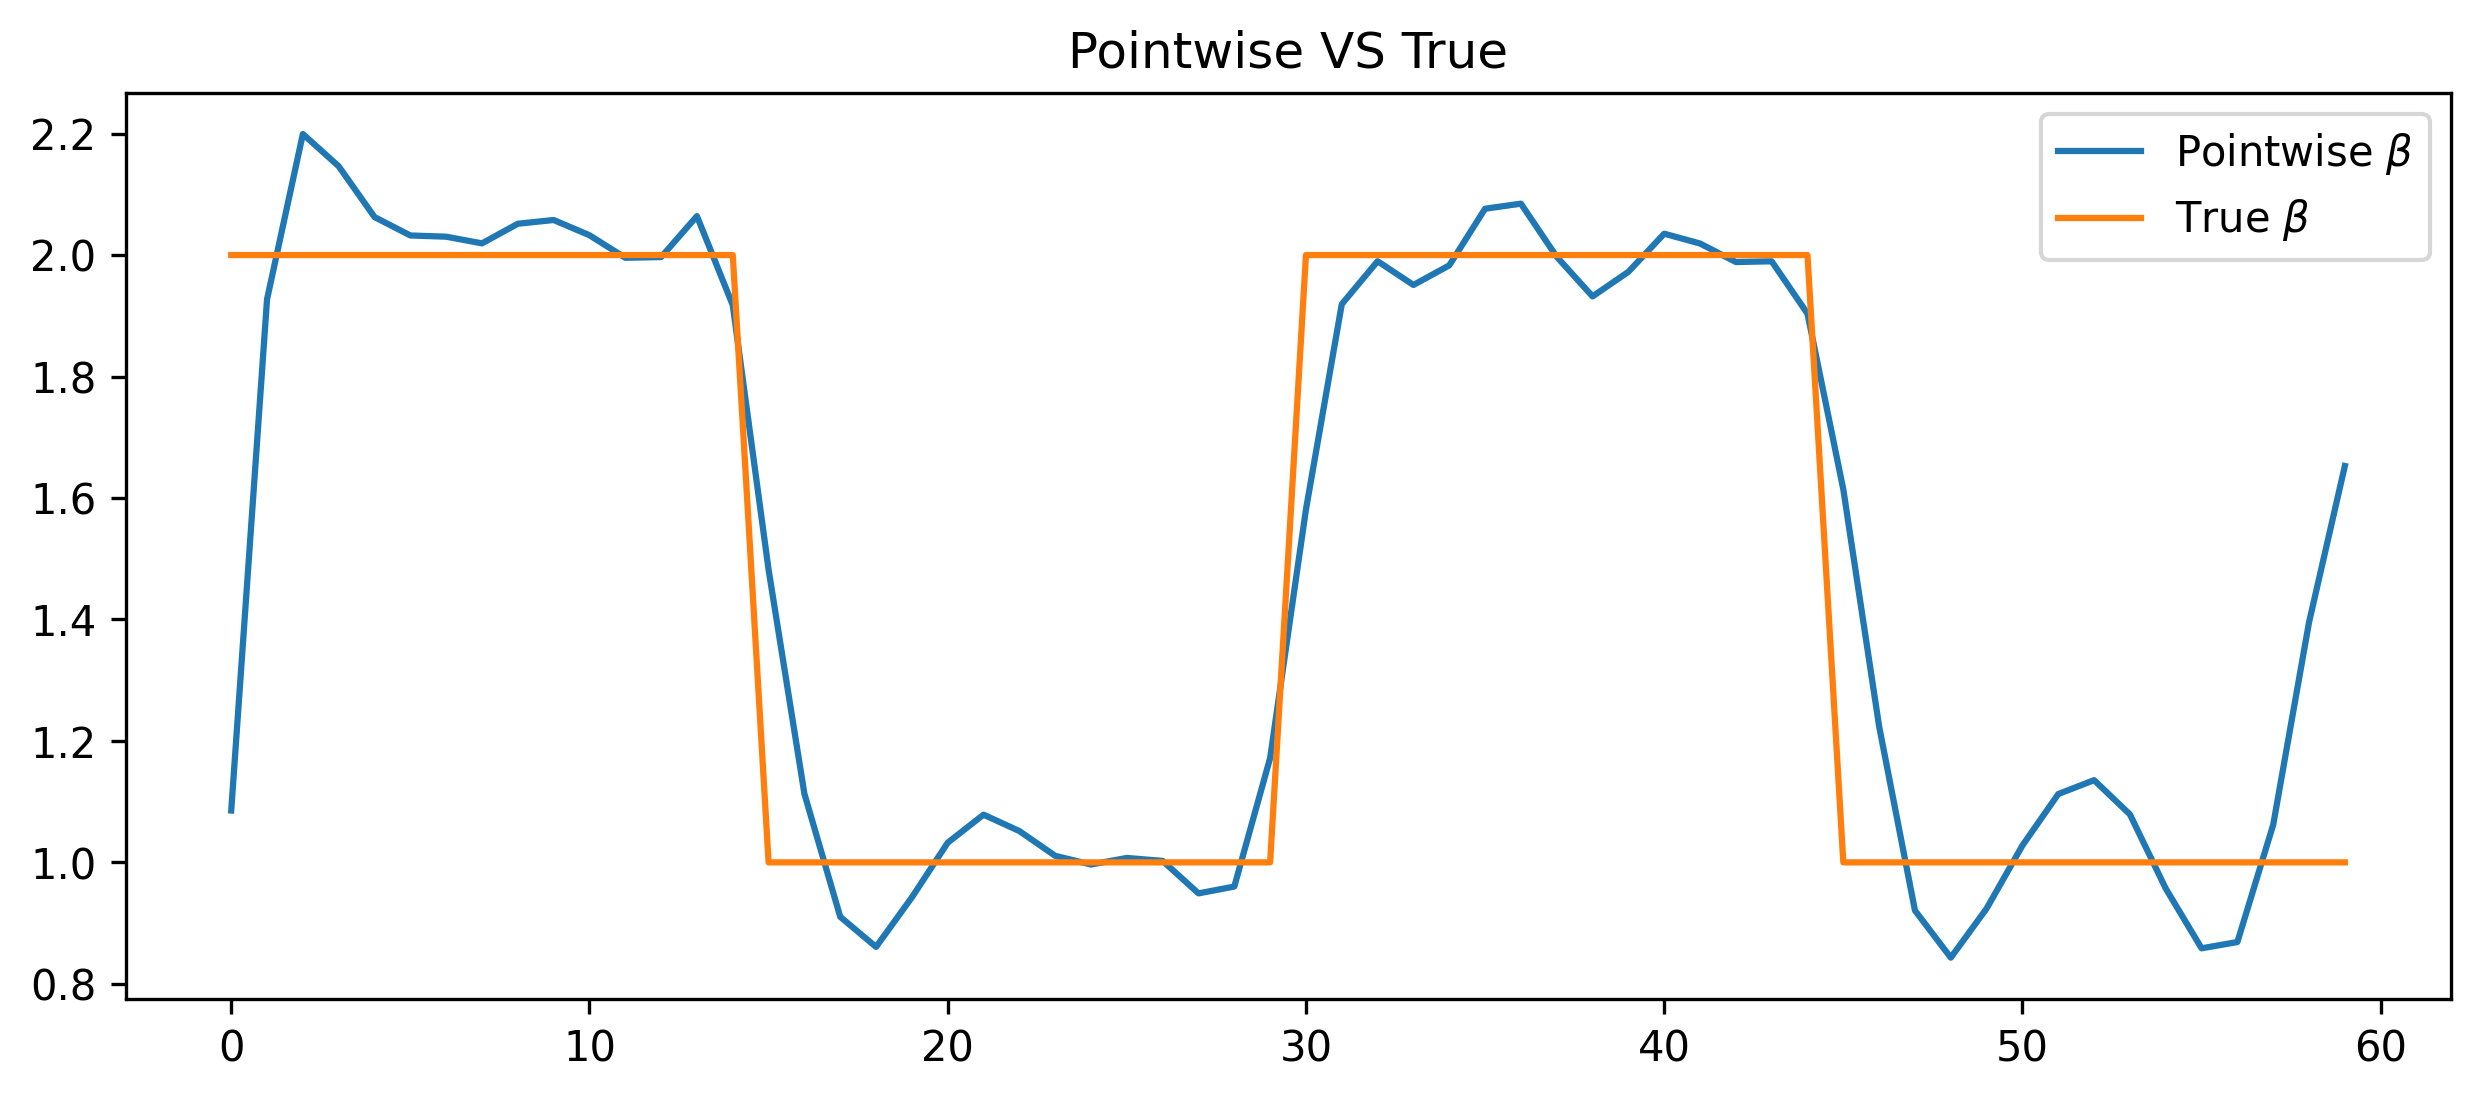

In [14]:
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

figsize(10, 4)

pointwise_xlatent_torch1 = torch.tensor(xInitExogenous, dtype=torch.double)
pointwise_xlatent_torch2 = torch.tensor(inferred_trajectory.transpose(), dtype=torch.double)
pointwise_xlatent_torch3 = torch.tensor(true_data, dtype=torch.double)
plt.plot(pointwise_theta_torch.detach().numpy()[:, 0], label=r'Pointwise $\beta$')
plt.plot(true_beta[::1000], label=r'True $\beta$')
plt.title('Pointwise VS True')
plt.legend()
plt.show()
true_theta_torch = torch.tensor(true_beta.reshape(-1, 1))

Iteration:  0 

Current index:  0
tensor(452.6905, dtype=torch.float64, grad_fn=<SumBackward0>)
0 -452.69052233834725
200 -529.186141717332
400 -557.1276958519561
600 -570.5068361747979
800 -577.8642708812588
1000 -582.7925237500974
1200 -586.4383616284134
1400 -589.2209789489119
1600 -591.3792627700263
1800 -593.0744072202144
2000 -594.4203595852559
2200 -595.499437018367
2400 -596.3718969324015
Update change point!
Updated change point list:  [2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Current index:  1
tensor(644.2105, dtype=torch.float64, grad_fn=<SumBackward0>)
0 -644.2105180194144
200 -661.7250398748669
400 -662.4905404692443
Update change point!
Updated change point list:  [1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Current index:  2
tensor(665.9986, dtype=torch.float64, grad_fn=<SumBackward0>)
0 -665.9986469414093
200 -666

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


<Figure size 3000x1200 with 0 Axes>

0


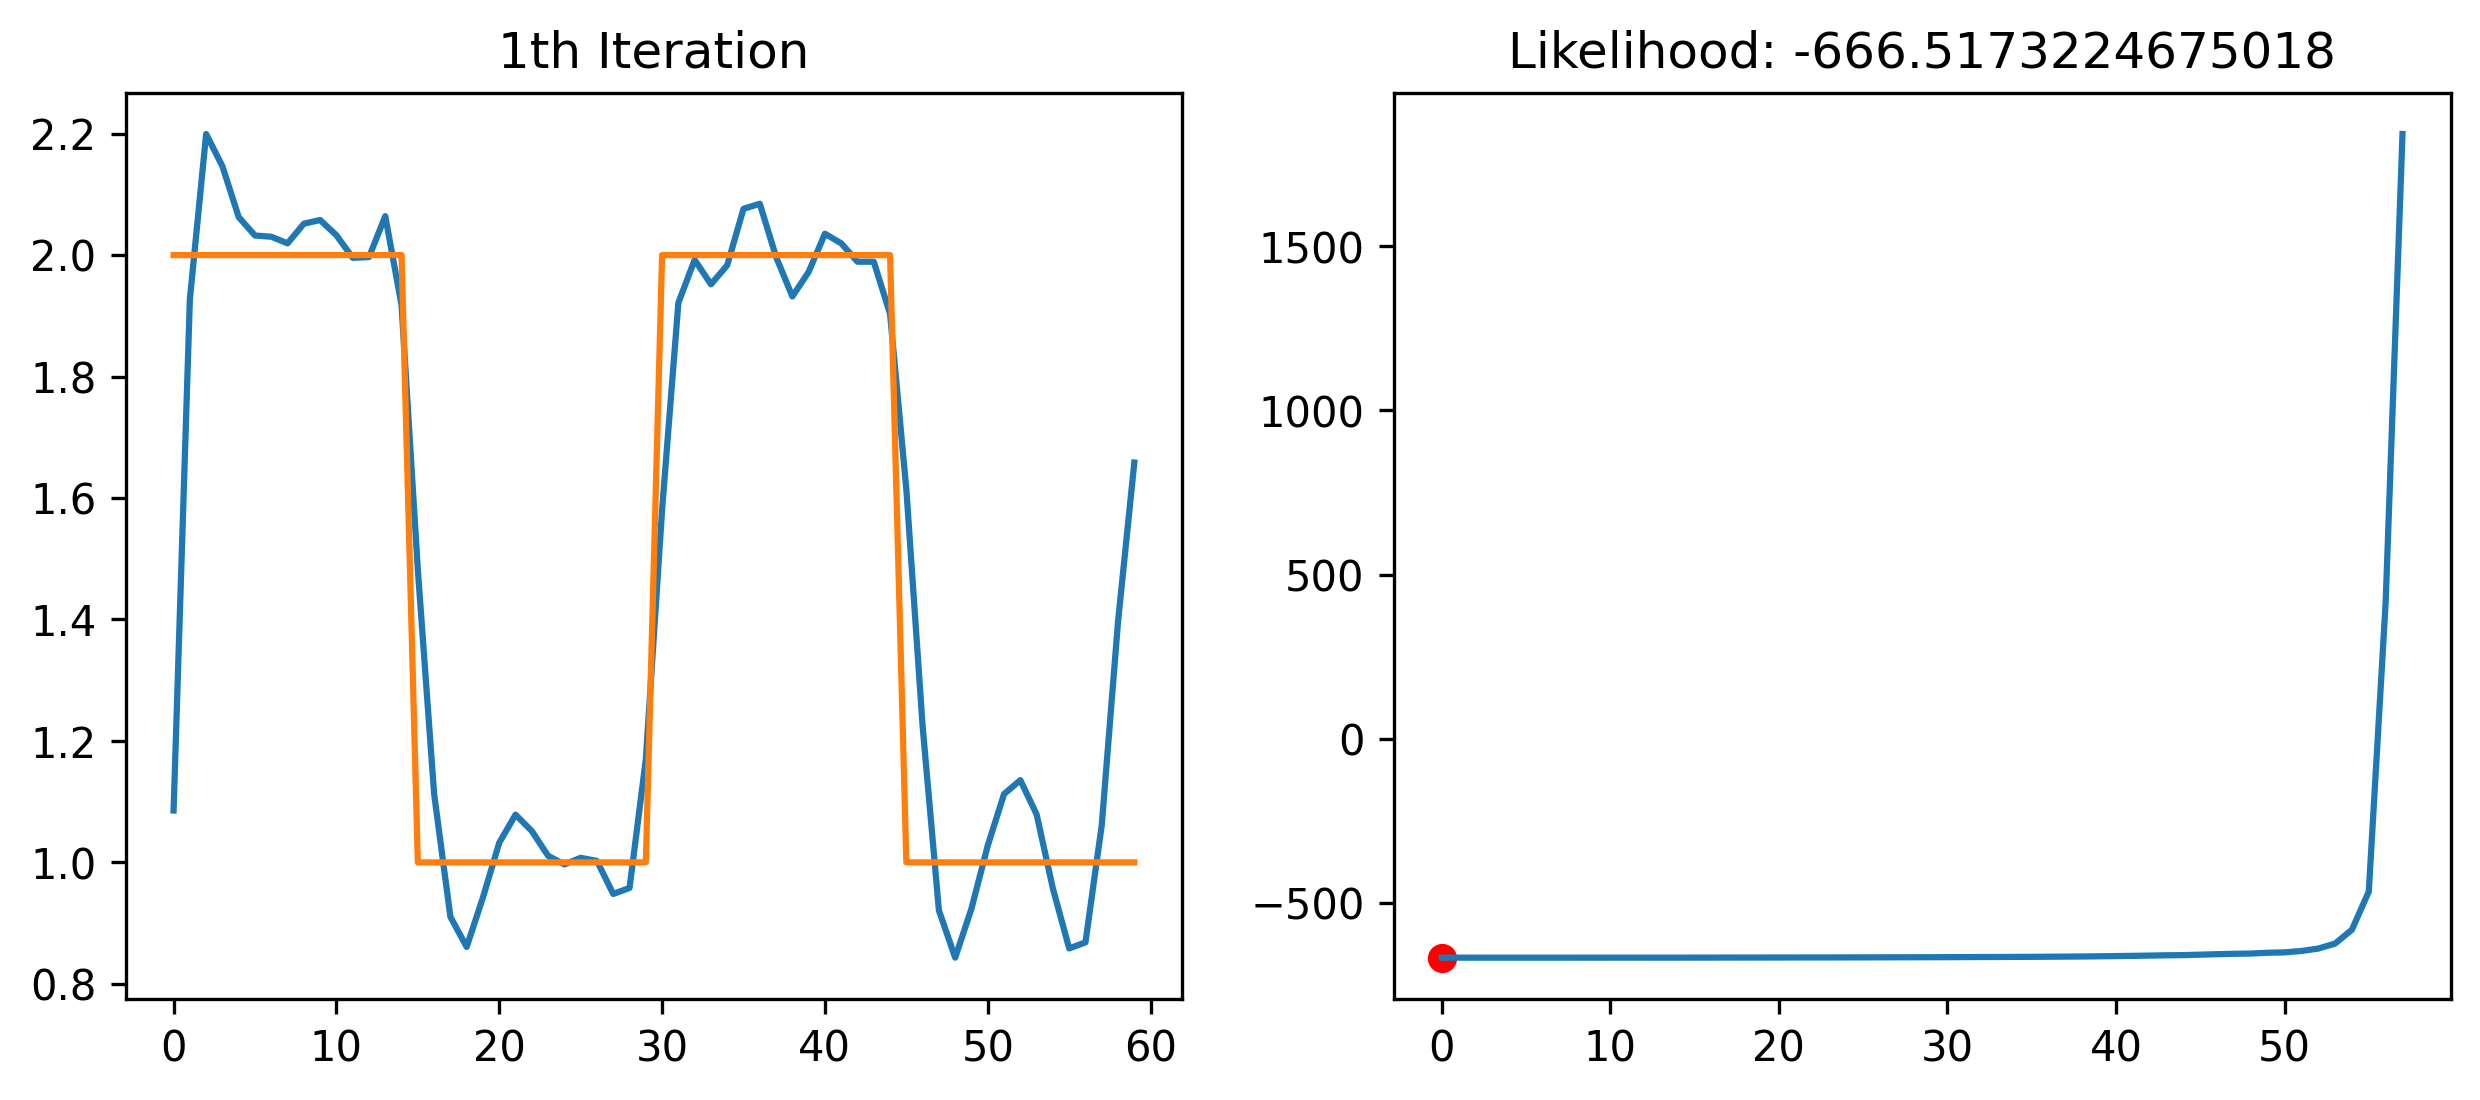

In [28]:
for i in range(1):
    print(i)
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(construct(torch.tensor(vals_ls[i]).reshape(-1, 1), occurence_times_ls[i].astype(int)).numpy().reshape(-1, 1))
    plt.plot(beta_series[::1000])
    ax1.set_title(str(i+1) + 'th Iteration')
    ax2 = plt.subplot(1, 2, 2)
    plt.plot(lik_ls)
    plt.scatter(np.array([i]), np.array([lik_ls[i]]), c='r')
    ax2.set_title('Likelihood: '+ str(lik_ls[i]))
    plt.show()

0 14849.721627215033
200 11592.066995348368
400 10465.099882337923
600 9623.471405003816
800 8881.006236933947
1000 8206.38929436431
1200 7593.055881004269
1400 7035.642922759887
1600 6529.047008121434
1800 6068.421798529144
2000 5649.186014568857
2200 5267.04412556285
2400 4918.018951527256
2600 4598.488547314887
2800 4305.216645592877
3000 4035.3669608772693
3200 3786.4970144457075
3400 3556.53367681132
3600 3343.7363706135166
3800 3146.653967988302
4000 2964.0798084057615
4200 2795.007801917766
4400 2638.591733687068
4600 2494.1093406841774
4800 2360.932119956879
5000 2238.5010155794193
5200 2126.3072925425645
5400 2023.8773788550423
5600 1930.7604534826082
5800 1846.5179756085442
6000 1770.714860172725
6200 1702.9127862022217
6400 1642.6623901474957
6600 1589.504150915326
6800 1542.961563833956
7000 1502.5428435702308
7200 1467.741526830952
7400 1438.039389155142
7600 1412.9112466703064
7800 1391.8317873214223
8000 1374.2840498755565
8200 1359.770420351956
8400 1347.8178641385596
8

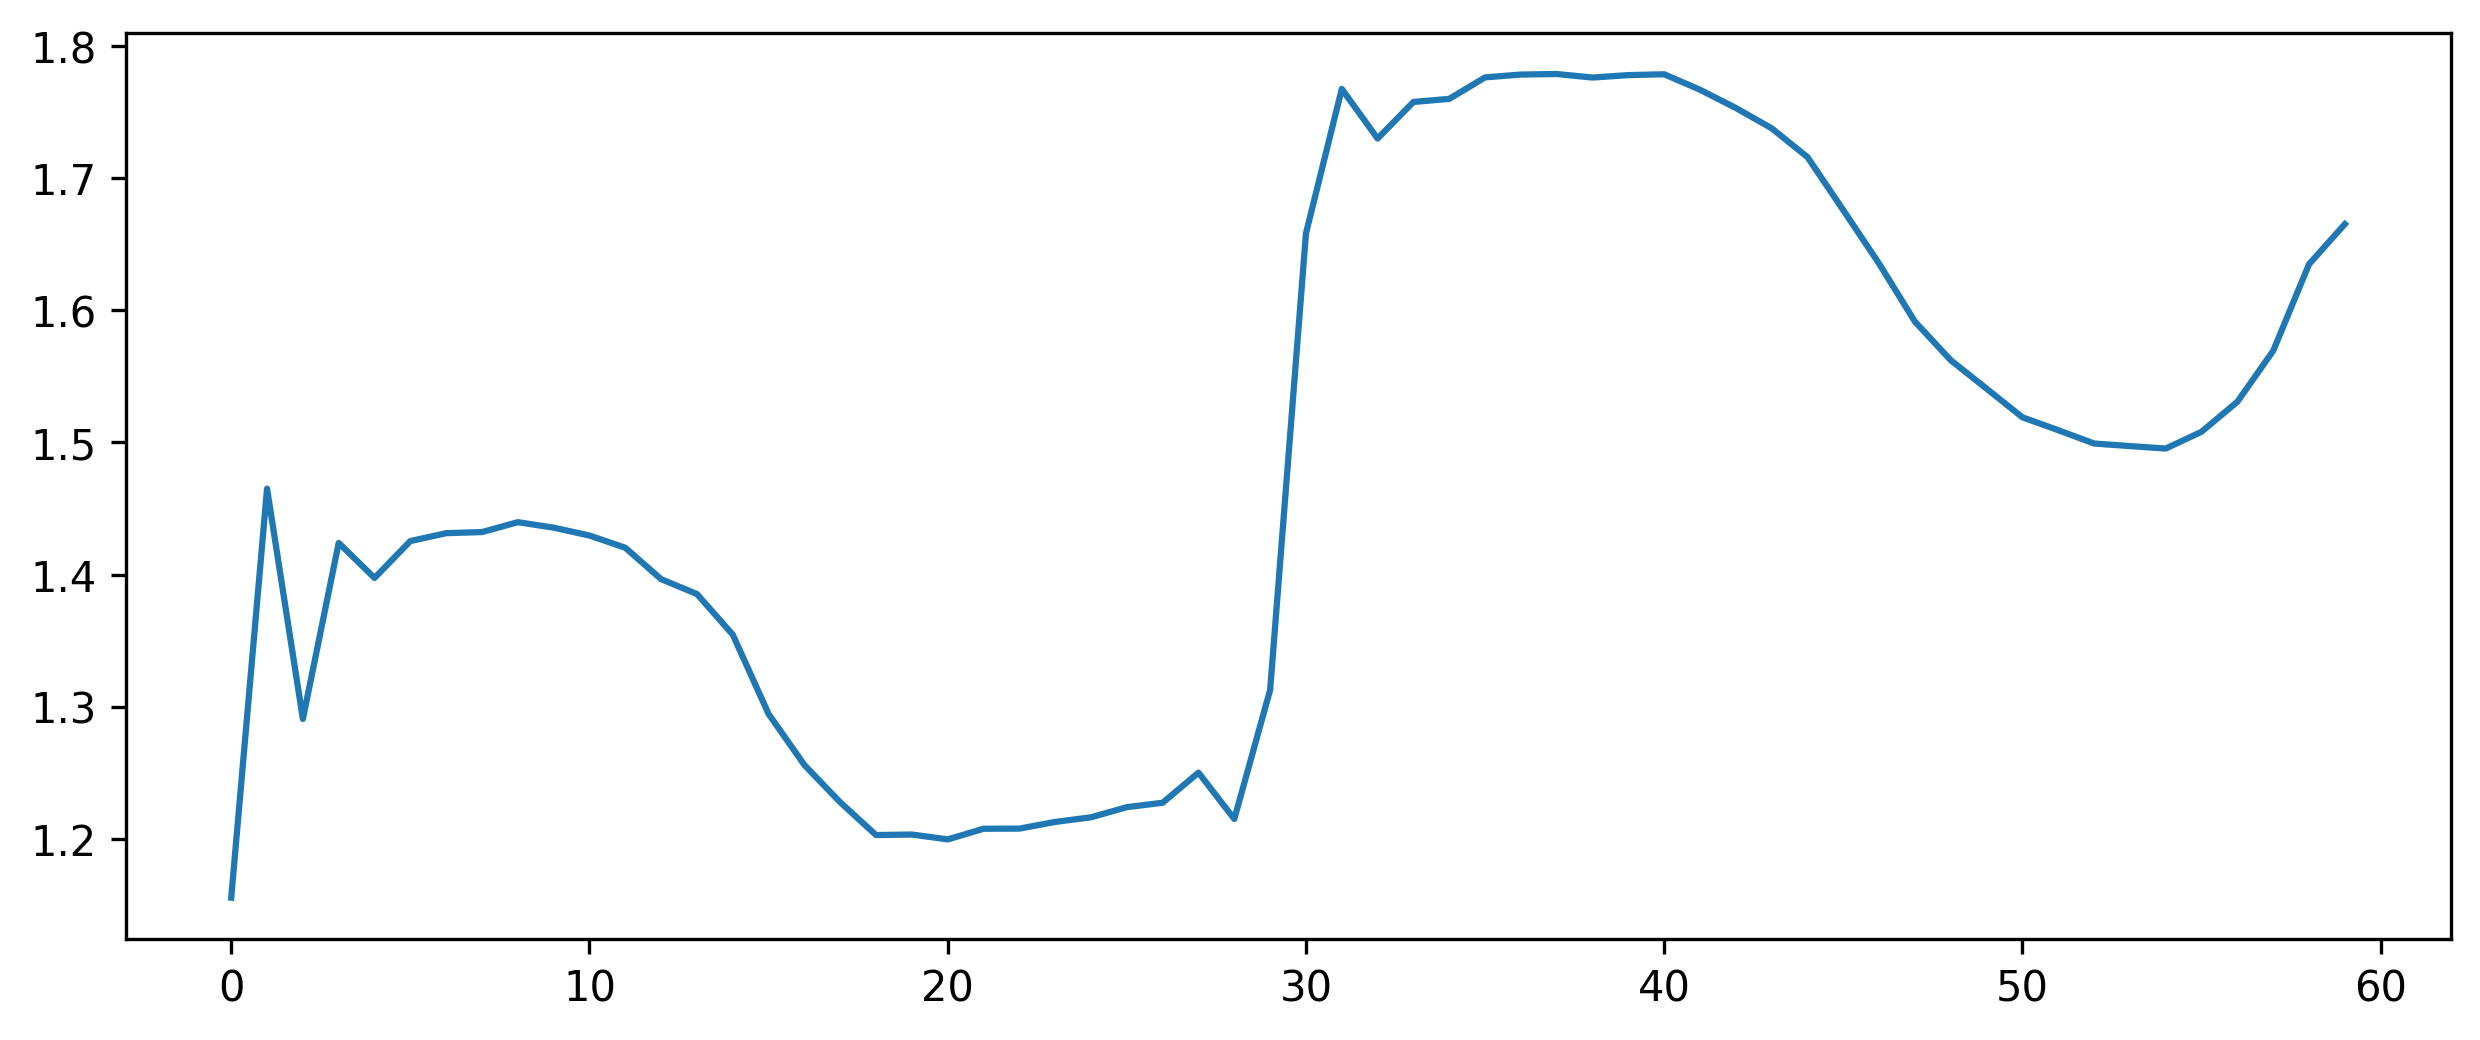

In [39]:
plt.plot(pointwise_theta_torch[:, 0].detach().numpy())

In [38]:
pointwise_theta_torch

tensor([[1.1557],
        [1.4651],
        [1.2909],
        [1.4240],
        [1.3975],
        [1.4254],
        [1.4314],
        [1.4322],
        [1.4397],
        [1.4356],
        [1.4296],
        [1.4204],
        [1.3966],
        [1.3854],
        [1.3547],
        [1.2946],
        [1.2560],
        [1.2278],
        [1.2030],
        [1.2035],
        [1.1998],
        [1.2078],
        [1.2079],
        [1.2130],
        [1.2165],
        [1.2241],
        [1.2275],
        [1.2503],
        [1.2152],
        [1.3128],
        [1.6581],
        [1.7674],
        [1.7299],
        [1.7576],
        [1.7599],
        [1.7762],
        [1.7783],
        [1.7787],
        [1.7761],
        [1.7779],
        [1.7785],
        [1.7668],
        [1.7530],
        [1.7377],
        [1.7159],
        [1.6757],
        [1.6352],
        [1.5914],
        [1.5622],
        [1.5407],
        [1.5191],
        [1.5093],
        [1.4992],
        [1.4973],
        [1.4954],
        [1

In [129]:
poisson.pmf(10, 0.01)

2.7283119316280243e-27

In [ ]:
def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, obs_per_day, positive_param=True):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res)


is_time_varying=[True, False, False, False]
TV_theta_mean = np.zeros(int(sum(is_time_varying)))
tv_index = 0
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == True:
        TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
        tv_index += 1

if use_trajectory == 'observation':
    pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
elif use_trajectory == 'inferred':
    pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
else:
    raise ValueError
tmp1 = np.array([TV_theta_mean])
initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == 0:
        param_name = param_names[thetaEachDim]
        locals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double)
        time_constant_param_ls.append(eval(param_name))

ydata = torch.from_numpy(yFull).double()
priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=10000, gamma=0.5)
cur_loss = 1e12
for epoch in range(n_iter[1]):
    pointwise_optimizer.zero_grad()
    # compute loss function
    llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, sigma_torch,
                                        ydata, CovAllDimensionsPyList, fOdeTorch,
                                        priorTemperature, obs_per_day)
    new_loss = -llik
    if epoch % 200 == 0:
        print(epoch, new_loss.item())
        diff = new_loss.item() - cur_loss
        if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
            break
        cur_loss = new_loss.item()
    new_loss.backward()
    pointwise_optimizer.step()
    pointwise_lr_scheduler.step()

In [ ]:
def construct(vals, occurence_times):
    ls = []
    for idx in range(len(vals)):
        if occurence_times[idx] != 0:
            for i in range(occurence_times[idx]):
                ls.append(vals[idx])
    return torch.cat(ls, axis=0).reshape(-1, vals.shape[1])
    
def new_likelihood(xlatent, vals, occurence_times, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature):
    new_theta = construct(vals, occurence_times)
    return pointwisethetasigmallikTorch(xlatent, new_theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, obs_per_day)



vals = pointwise_theta_torch.detach().clone()

# Initialize occurence times, sum(cur_occurence_times) = len(theta)
occurence_times = np.ones(len(vals)).astype(int)
pointwise_xlatent_torch.requires_grad = False
sigma_torch.requires_grad = False
total_iter = 58
vals_ls = np.zeros((total_iter, len(vals)))
occurence_times_ls = np.zeros((total_iter, len(vals)))
constant_ls = []
lik_ls = np.zeros(total_iter)
for EachIter in range(total_iter):
    print('Iteration: ', EachIter, '\n')
    cur_loss = np.inf
    cur_best_idx = -1
    cur_occurence_times = occurence_times.copy()
    for idx in range(len(vals)-1):
        if occurence_times[idx] == 0:
            continue
        else:
            print('Current index: ', idx)
            # find the next index of theta value
            next_idx = idx + 1
            while next_idx <= len(vals)-1:
                if occurence_times[next_idx]:
                    break
                next_idx += 1
            # if there is no such next index, continue to the next iteration  
            if next_idx >= len(vals):
                continue      
            cur_vals = vals.detach().clone()
            new_val = (cur_occurence_times[idx] * cur_vals[idx] + cur_occurence_times[next_idx] * cur_vals[next_idx]) / (cur_occurence_times[idx]+cur_occurence_times[next_idx])
            new_vals_tmp = cur_vals.detach().clone()
            new_vals_tmp[idx], new_vals_tmp[next_idx] = new_val, new_val
            new_occurence_times = cur_occurence_times.copy()
            new_occurence_times[idx] = cur_occurence_times[idx] + cur_occurence_times[next_idx]
            new_occurence_times[next_idx] = 0
            pointwise_xlatent_torch_tmp = pointwise_xlatent_torch.detach().clone()
            pointwise_xlatent_torch_tmp.requires_grad = True
            new_vals_tmp.requires_grad = True
            time_constant_param_ls_tmp = time_constant_param_ls.copy()
            sigma_torch_tmp = sigma_torch.detach().clone()
            sigma_torch_tmp.requires_grad = True
            # Define new initial theta
            print(new_likelihood(pointwise_xlatent_torch_tmp, new_vals_tmp, new_occurence_times, time_constant_param_ls_tmp, sigma_torch_tmp,
                                            ydata, CovAllDimensionsPyList, fOdeTorch,
                                            priorTemperature))
            pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch_tmp, new_vals_tmp, sigma_torch_tmp] + time_constant_param_ls_tmp, lr=1e-4)  # , weight_decay = 1.0
            pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
            cur_loss_tmp = np.inf
            for epoch in range(100000):
                pointwise_optimizer.zero_grad()
                # compute loss function
                llik = new_likelihood(pointwise_xlatent_torch_tmp, new_vals_tmp, new_occurence_times, time_constant_param_ls, sigma_torch,
                                            ydata, CovAllDimensionsPyList, fOdeTorch,
                                            priorTemperature)
                new_loss = -llik
                if epoch % 200 == 0:
                    print(epoch, new_loss.item())
                    diff = new_loss.item() - cur_loss_tmp
                    if torch.isnan(new_loss) == False and diff > -1. and diff < 1.:
                        break
                    cur_loss_tmp = new_loss.item()
                new_loss.backward()
                pointwise_optimizer.step()
                pointwise_lr_scheduler.step()
            if cur_loss > new_loss.item():
                cur_loss = new_loss.item()
                cur_best_idx = idx
                cur_best_occurence_times = new_occurence_times.copy()
                print('Update change point!')
                cur_best_vals = new_vals_tmp.detach().clone()
                print('Updated change point list: ', cur_best_occurence_times)
                cur_best_xlatent = pointwise_xlatent_torch_tmp.detach().clone()
                
    occurence_times = cur_best_occurence_times.copy()
    occurence_times_ls[EachIter] = occurence_times.copy()
    pointwise_xlatent_torch = cur_best_xlatent.clone()
    vals = cur_best_vals.clone()
    vals_ls[EachIter] = vals.detach().numpy()[:, 0]
    lik_ls[EachIter] = cur_loss
    constant_ls.append(time_constant_param_ls.copy())
    
np.save('new-occurence_times_ls.npy', occurence_times_ls)
np.save('new-vals_ls.npy', vals_ls)
np.save('new-lik_ls.npy', lik_ls)

In [ ]:
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

figsize(10, 4)
plt.subplots_adjust(top=1,bottom=0,left=0,right=1, wspace =0, hspace =0)
ax1 = plt.subplot(1, 2, 1) # 两行一列，位置是1的子图

def construct(vals, occurence_times):
    ls = []
    for idx in range(len(vals)):
        if occurence_times[idx] != 0:
            for i in range(occurence_times[idx]):
                ls.append(vals[idx])
    return torch.cat(ls, axis=0).reshape(-1, vals.shape[1])


for i in range(57):
    print(i)
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(construct(torch.tensor(vals_ls[i]).reshape(-1, 1), occurence_times_ls[i].astype(int)).numpy().reshape(-1, 1))
    plt.plot(beta_series[::1000])
    ax1.set_title(str(i+1) + 'th Iteration')
    ax2 = plt.subplot(1, 2, 2)
    plt.plot(-lik_ls)
    plt.scatter(np.array([i]), -np.array([lik_ls[i]]), c='r')
    ax2.set_title('Likelihood: '+ str(-lik_ls[i]))
    plt.savefig('new-SEIRD-plots/plot-'+str(i)+'.png', bbox_inches='tight')
    plt.clf()